In [36]:
#pip install pmdarima

# Time Series Model with ARIMA 

[10-year US Government Bond Yields (long-term interest rate)](https://datahub.io/core/bond-yields-us-10y#readme)
***

### Steps for ARIMA implementation 

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

# Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.

In [37]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import kpss

import scipy
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)

Matplotlib: 3.1.1
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2



# Preprocessing Data

Within reading in our dataframe we can include our datetime and index functions upon our univariate data. 


In [38]:
# Read in data
month = pd.read_excel('/Users/jasonrobinson/Documents/Projects/time_series_analysis/data/U.S. 10-yr-Bond.xls', parse_dates=['Date'], index_col='Date')
print(month.shape)
month.head()

(808, 1)


,Rate
Date,
1953-04-30,2.83
1953-05-31,3.05
1953-06-30,3.11
1953-07-31,2.93
1953-08-31,2.95



### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

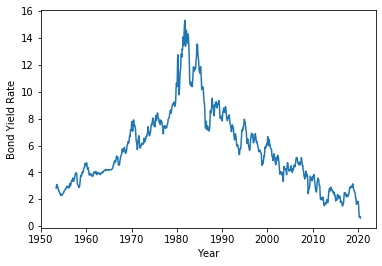

In [39]:
# Full range examination - significant drop every 5 years
plt.xlabel('Year')
plt.ylabel('Bond Yield Rate')
plt.plot(month)
plt.plot(grid=True)
plt.show();

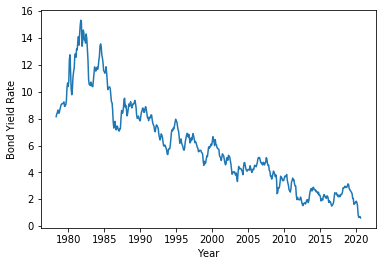

In [40]:
# 40-year examination - significant drop every 5 years
plt.xlabel('Year')
plt.ylabel('Bond Yield Rate')
plt.plot(month[300:])
plt.plot(grid=True)
plt.show();

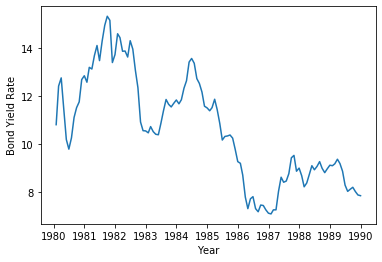

In [41]:
# Let's focus in more on the 80's
# 40-year examination - significant drop every 5 years
plt.xlabel('Year')
plt.ylabel('Bond Yield Rate')
plt.plot(month['1980':'1989'])
plt.plot(grid=True)
plt.show();

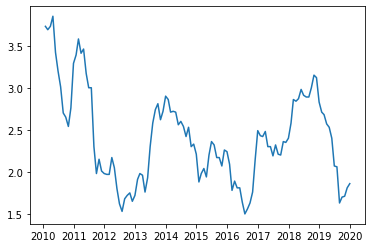

In [42]:
plt.plot(month['2010':'2019'][['Rate']]);

# Differencing

First order difference with _mean_ and _standard deviation_.

In [43]:
month_log = np.log(month["Rate"])
month_diff = month_log.diff().dropna()

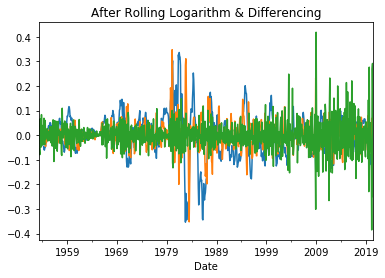

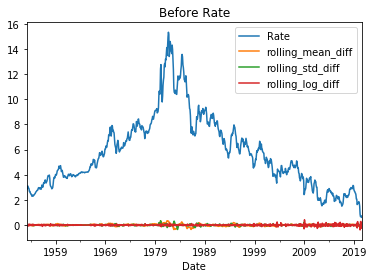

In [44]:
# Differentiate our data to acquire rolling mean
rolling_mean = month['Rate'].rolling(window = 12).mean().dropna()
rolling_std = month['Rate'].rolling(window = 12).std().dropna()

# Current value - past(previous) value
month['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
month['rolling_std_diff'] = rolling_std - rolling_std.shift()
month['rolling_log_diff'] = month_diff - month_diff.shift()

# Differentiated plots
ax1 = plt.subplot()
month['rolling_mean_diff'].plot(title='After Rolling Mean & Differencing');
month['rolling_std_diff'].plot(title='After Rolling Standard Deviation & Differencing');
month['rolling_log_diff'].plot(title='After Rolling Logarithm & Differencing') 

# Before plot
ax2 = plt.subplot()
month.plot(title='Before Rate');

In [45]:
# Remove remaining null values
month_diff = month['rolling_log_diff'].dropna()


### Seasonal decomposition

Seasonal decomposition

In [46]:
# Decompose trend, seasonality, residuals
decompose_data = seasonal_decompose(month_diff, model="additive")

In [47]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
    )

In [48]:
# Using plotly to demonstrate seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(month['Rate'], model='additive', period=12)
fig = plot_seasonal_decompose(decompose_data)
fig.show()

Standard deviation appears to be the least effective at differencing the time series, while log transformation is the right amount of differencing to make the data stationary.


### Test for Stationarity

Visually we see that our time series is stationary, but to confirm, let us check statistics through the _Augmented Dickey-Fuller Test_ (ADFTest) or the _Kwiatkowski-Phillips-Schmidt-Shin_ (KPSS) _test_, that can tell us if our p-value is greater than 95% to be considered for rejection or failure to reject. 

In [49]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month["Rate"])

(0.7319408103900956, True)


##  Make Series Stationary


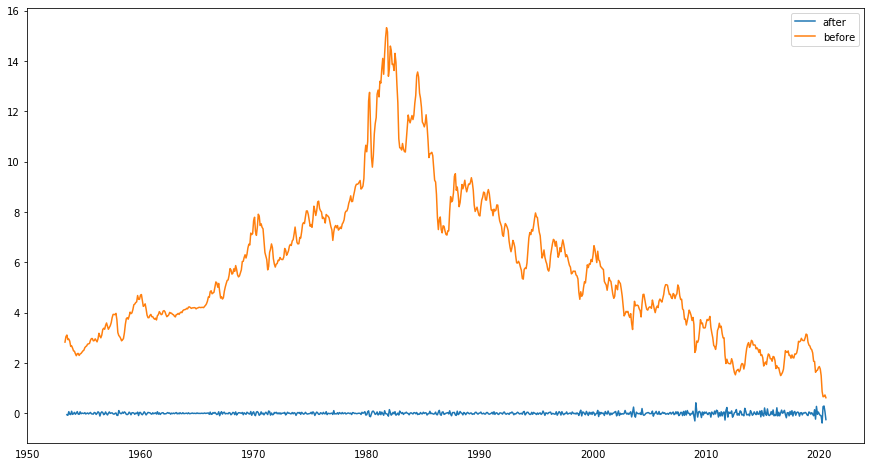

In [50]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month_diff,label="after")
plt.plot(month['Rate'],label="before")
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.legend()
plt.show()


### Confirm Stationarity

Here our time series should be in the form of stationary as our plot suggests as it appears to be stationary, but let's apply KPSS for confirmation.

The p-value is slightly under the threshold of significance, so given that the null hypothesis is non-stationary, we would fail to reject the null and accept the alternative that the series is stationary.

In [51]:
from statsmodels.tsa.stattools import kpss


def kpss_test(month):
    print("Results of KPSS Test:")
    kpsstest = kpss(month_diff, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    
    
kpss_test(month)

Results of KPSS Test:
Test Statistic             0.160310
p-value                    0.038075
Lags Used                229.000000
Critical Value (10%)       0.119000
Critical Value (5%)        0.146000
Critical Value (2.5%)      0.176000
Critical Value (1%)        0.216000
dtype: float64


# ARIMA Building

After confirming that our data is stationary, we can now build our ARIMA model to predict the bond rate for a period of 3-5 years. To help with determing the parameters for the model we will apply the _Auto Correlation Function_ (ACF) and the _Partial Auto Correlation Function_ (PACF). 


### ACF and PACF

We can use these two functions to allow us to see at which level of lag is most significant towards the current value.


In [52]:
# Autocorrelation and Partial Autocorrelation
acf_month = acf(month_diff)
pacf_month = pacf(month_diff)

In [53]:
np.round(acf_month, 2)

array([ 1.  , -0.25, -0.27,  0.02,  0.01,  0.  , -0.03, -0.  , -0.  ,
        0.02, -0.  ,  0.05, -0.03, -0.05,  0.01,  0.05,  0.01, -0.08,
        0.05, -0.03,  0.07, -0.03, -0.01,  0.03, -0.01, -0.03,  0.04,
       -0.03,  0.  ,  0.02,  0.03, -0.08,  0.02,  0.06, -0.08,  0.07,
       -0.  , -0.08,  0.08, -0.03, -0.04])

In [54]:
np.round(pacf_month, 2)

array([ 1.  , -0.25, -0.36, -0.2 , -0.19, -0.14, -0.16, -0.14, -0.15,
       -0.11, -0.12, -0.02, -0.05, -0.07, -0.07, -0.01,  0.01, -0.07,
        0.  , -0.09,  0.03, -0.05, -0.02,  0.  ,  0.01, -0.04,  0.02,
       -0.05, -0.01, -0.02,  0.04, -0.09, -0.02,  0.02, -0.08,  0.06,
        0.02, -0.04,  0.07,  0.  , -0.02])

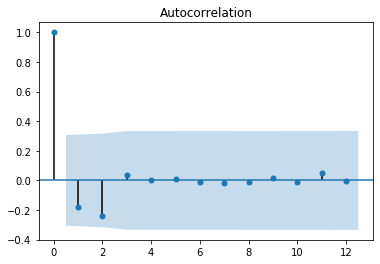

In [55]:
# Visualize our lags and confidence intervals
# 2 lags behind for the autoregressive part
plot_acf(acf_month, lags=12);

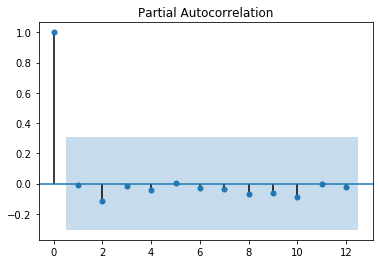

In [56]:
plot_pacf(pacf_month, lags=12);


In [57]:
df_pacf = acf(month_diff, nlags=12)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x= np.arange(len(df_pacf)),
    y= df_pacf,
    name='ACF',
    ))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title="Autocorrelation",
    xaxis_title="Lag",
    yaxis_title="Autocorrelation",
         #autosize=False,
         width=800,
         height=300,
    )
fig.show()

df_pacf = pacf(month_diff, nlags=12)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x= np.arange(len(df_pacf)),
    y= df_pacf,
    name= 'PACF',
    ))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    title="Partial Autocorrelation",
    xaxis_title="Lag",
    yaxis_title="Partial Autocorrelation",
         autosize=True,
         width=800,
         height=300,
    )
fig.show()

From the acf and pacf we can determine that in the autocorrelation the first two values are outside of our confidence interval.


## ARIMA

Beginning with ARIMA we will compare other family models for demonstration purposes such as SARIMAX and then Auto-ARIMA.

From our correlation plots the ACF tells us most significant lags in respect to the number of months of the bond yield rate being low or experiencing the greatest change in variance.

In [58]:
# For an arima model we need to split our training and test data
train = month_diff.iloc[:len(month_diff)-12]
test = month_diff.iloc[len(month_diff)-12:]

Use acf and pacf values to determine parameters for the type of arima model we will use for our predictions. According to the lags we will use 0 as our (_AR_), 1 (_I_) for our inegration of differencing order, and 0 (_MA_) for our moving average. Thus we want to builda a (2, 1, 0) ARIMA model.

In [59]:
# Fit our model ARIMA(2,1,0)
model = ARIMA(month_diff, order=(2,1,0))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.rolling_log_diff   No. Observations:                  805
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 938.707
Method:                       css-mle   S.D. of innovations              0.075
Date:                Sun, 02 Oct 2022   AIC                          -1869.414
Time:                        01:43:13   BIC                          -1850.651
Sample:                    07-31-1953   HQIC                         -1862.209
                         - 07-31-2020                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     1.599e-05      0.001      0.013      0.989      -0.002       0.002
ar.L1.D.rolling_log_diff    -0.7399      0.031    -23.680      0.000      -0.801      -0.679
ar.L2.D.rolling_log_diff    -0.4962      0.031    -15.834      0.000      -0.558      -0.435
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7455           -1.2081j            1.4196           -0.3380
AR.2           -0.7455           +1.2081j            1.4196            0.3380
-----------------------------------------------------------------------------
"""


## Auto-ARIMA

In [60]:
#pd.options.display.max_rows=None
#month['rolling_mean_diff'] = month['rolling_mean_diff'].dropna(inplace=False)
#month['rolling_mean_diff']

In [61]:
"""

    Parameters:
    ---------- 
    start_p : int
        Initial value for p, the order (or number of time lags) of the autoregressive model.
    d : int
        The order of first differencing.
    start_q : int
        Initial value for q, the order of the moving-average model.
    start_P : int
        Initial value for P, the order of the seasonal autoregressive model.
    D : int
        The order of seasonal differencing.
    start_Q : int
        Initial value for Q, the order of the seasonal moving-average model.
    m : int
        The number of time steps for a single seasonal period.

    Input: (2,1,0)(1,1,0)12
    ----------

"""
month_fit = auto_arima(month_diff,start_p=2, d=1, start_q=1, 
                          max_p=3, max_d=3, max_q=3, start_P=1, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace=True,
                          supress_warnings=True,stepwise=True,
                          random_state=42,n_fits=50)

month_fit.summary().tables[1]

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-910.123, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1319.854, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1112.177, Time=0.17 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1411.055, Time=0.93 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-1440.586, Time=2.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=12.68 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.43 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=-1243.523, Time=1.73 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-1670.840, Time=2.07 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-1627.555, Time=1.90 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=10.17 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.59 sec
 ARIMA(3,1,0)(3,1,0)[12]             : A

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.9210,0.018,-50.499,0.000,-0.957,-0.885
ar.L2,-0.7928,0.022,-35.608,0.000,-0.836,-0.749
ar.L3,-0.3777,0.020,-19.058,0.000,-0.417,-0.339
ar.S.L12,-0.7954,0.029,-27.479,0.000,-0.852,-0.739
ar.S.L24,-0.5308,0.033,-16.022,0.000,-0.596,-0.466
ar.S.L36,-0.2721,0.032,-8.480,0.000,-0.335,-0.209
sigma2,0.0060,0.000,35.393,0.000,0.006,0.006


## Evaluate Auto-ARIMA model using GridSearch

In [62]:
# Evaluate parameters
p_values = [0, 1]
d_values = range(0, 3)
q_values = [0, 1, 2, 3]

In [63]:
# Evaluate model using grid search
def evaluate_models(month, p_values, d_values, q_values):
    dataset = month_diff.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [64]:
# Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [65]:
# evaluate_models(month_diff, p_values, d_values, q_values)

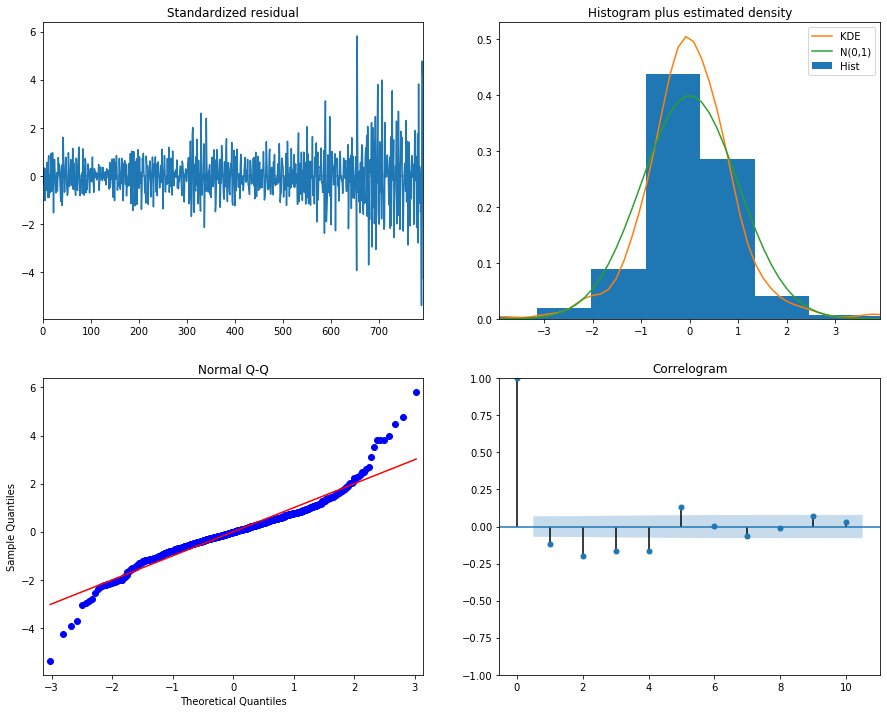

In [66]:
month_fit.plot_diagnostics(figsize=(15, 12))
plt.show();

****


## SARIMAX - (Not Included in demonstration)

Using the SARIMAX model we will incorporate two orders. The first-order is p,d,q and the other is P,D,Q,m to accountfor seasonality.

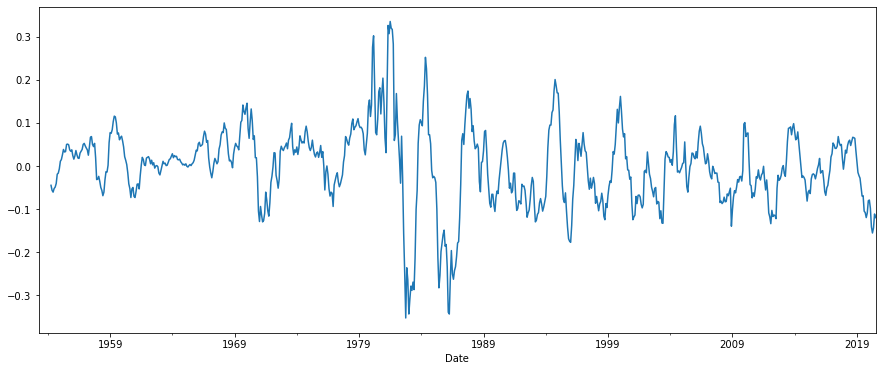

In [67]:
month['rolling_mean_diff'].plot(figsize=(15, 6))
plt.show()

In [68]:
train = month['rolling_mean_diff'].iloc[:len(month['rolling_mean_diff'])-12]
test = month['rolling_mean_diff'].iloc[len(month['rolling_mean_diff'])-12:]
test.index, train

(DatetimeIndex(['2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
                '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
                '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31'],
               dtype='datetime64[ns]', name='Date', freq=None),
 Date
 1953-04-30         NaN
 1953-05-31         NaN
 1953-06-30         NaN
 1953-07-31         NaN
 1953-08-31         NaN
                 ...   
 2019-03-31   -0.022500
 2019-04-30   -0.028333
 2019-05-31   -0.048333
 2019-06-30   -0.070000
 2019-07-31   -0.069167
 Name: rolling_mean_diff, Length: 796, dtype: float64)

In [69]:
# Split data into train / test sets
#train = month['Rate'].iloc[:len(month['Rate'])-12]
#test = month['Rate'].iloc[len(month['Rate'])-12:] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX

# We will use the best model from auto-arimaa (3,1,0)(3,1,0)[12]  
model = SARIMAX(train, 
                order = (3, 1, 0), 
                seasonal_order =(3, 1, 0, 12))
  
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.67170D+00    |proj g|=  1.23468D+01


 This problem is unconstrained.



At iterate    5    f= -1.88666D+00    |proj g|=  6.85740D-02

At iterate   10    f= -1.88847D+00    |proj g|=  1.76131D+00

At iterate   15    f= -1.89013D+00    |proj g|=  1.08477D-02

At iterate   20    f= -1.89031D+00    |proj g|=  1.40848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     43      1     0     0   1.023D-03  -1.890D+00
  F =  -1.8903079429677776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  rolling_mean_diff   No. Observations:                  796
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                1504.685
Date:                            Sun, 02 Oct 2022   AIC                          -2995.370
Time:                                    01:45:00   BIC                          -2962.728
Sample:                                04-30-1953   HQIC                         -2982.818
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4139      0.022     18.544      0.000       0.370       0.458
ar.L2         -0.2842      0.027    -10.544      0.000      -0.337      -0.231
ar.L3          0.0889      0.023      3.888      0.000       0.044       0.134
ar.S.L12      -1.2394      0.025    -49.413      0.000      -1.289      -1.190
ar.S.L24      -0.9477      0.037    -25.582      0.000      -1.020      -0.875
ar.S.L36      -0.4050      0.029    -14.073      0.000      -0.461      -0.349
sigma2         0.0009   2.73e-05     33.116      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               852.30
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
pred = result.get_prediction(start='2018-08-31', dynamic=False)
pred_ci = pred.conf_int()

In [77]:
#pred = month['rolling_mean_diff'][750:-1]
#pred.pred_ci.plot(color='red', label='Predicted')
#plt.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], 
#                 color='blue', alpha=.2)
#
#plt.plot(month['Rate'], label='Rate')
#plt.plot(train, label='First-order difference', color='orange')
#plt.plot(test, label='Actual', alpha=0.7)
#plt.title('SARIMA Model')
#plt.legend()
#plt.show()
;

''

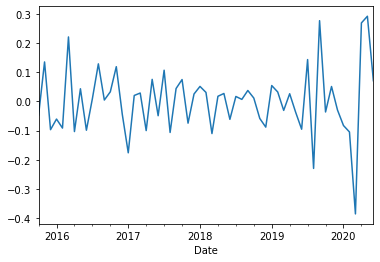

In [88]:
# Rises every 6 months (seasonal)
month['rolling_log_diff'][750:-1].plot();

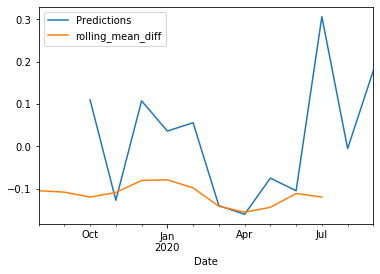

In [85]:
start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

Data not coverging. Predictions too far off to generalize.

In [80]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

rmse(test, predictions)
mean_squared_error(test, predictions)

0.01030358696646051

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.46575D-01    |proj g|=  2.41296D+00


 This problem is unconstrained.



At iterate    5    f= -9.66314D-01    |proj g|=  2.22772D-02

At iterate   10    f= -9.67079D-01    |proj g|=  9.35207D-02

At iterate   15    f= -9.67099D-01    |proj g|=  3.11190D-03

At iterate   20    f= -9.67100D-01    |proj g|=  2.90011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   3.002D-04  -9.671D-01
  F = -0.96709988149775439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


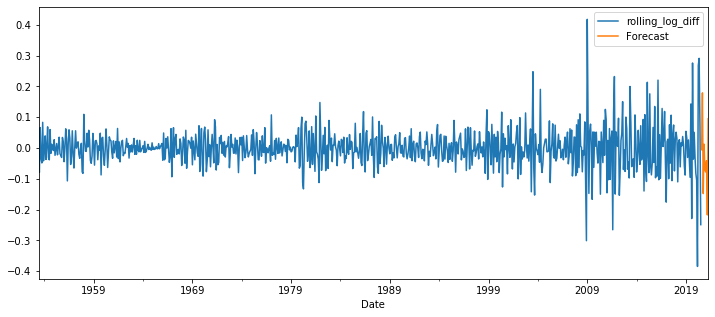

In [81]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (2, 1, 0), 
                        seasonal_order =(1, 1, 0, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 3, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);



### Alternate version


In [82]:
mod = sm.tsa.statespace.SARIMAX(month['Rate'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.Rate   No. Observations:                  795
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -197.806
Date:                            Sun, 02 Oct 2022   AIC                            403.613
Time:                                    01:49:26   BIC                            422.326
Sample:                                05-31-1954   HQIC                           410.804
                                     - 07-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3582      0.020     18.041      0.000       0.319       0.397
ar.L2         -0.2083      0.023   

In [83]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_ci

,lower D.DS12.Rate,upper D.DS12.Rate
1954-05-31,-0.754089,0.754089
1954-06-30,-0.761700,0.678712
1954-07-31,-0.693157,0.715665
1954-08-31,-0.658222,0.750600
1954-09-30,-0.711021,0.697800
...,...,...
2020-03-31,-0.672293,0.541285
2020-04-30,-0.693182,0.520396
2020-05-31,-0.440707,0.772871
2020-06-30,-0.425441,0.788136
